In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from shelter import Locationgenerator as lg


This script consists out of 
- the selection of shelter locations, 
- the zoning of areas related to each shelter location 

In [2]:
# Determine the analysis location: southwest of Antakya, Turkey
n = 36.203219
e = 36.162786
s = 36.169400
w = 36.112595

In [3]:
"""decide on which features you want to select the area features (for now, we continue working with sportsfields)"""
nature = {"landuse": ["grass", "greenfield", "brownfield", "recreation_ground", "village_green", "Meadow", "leasure", "agriculture", "farmland", "orchard"],
           "landcover":"yes", "area": "yes", "leisure": ["nature_reserve", "garden", "	dog_park", "park", "pitch", "track"]} 

# sportsfield = ox.features_from_bbox(n,e,s,w, nature)

sportsfield = ox.features_from_bbox(n,e,s,w, {"leisure": "pitch"})
graph = ox.graph_from_bbox(n,e,s,w, simplify=True)


In [5]:
# Make sure all data is using the same coordination system (EPSG 4326)
sportsfieldcrs = sportsfield.to_crs({'init': 'epsg:32633'})

# Select sportsfields based on a minimum area
sportsfieldcrs["area"] = sportsfieldcrs['geometry'].area
filtered_sportsfield = sportsfieldcrs[sportsfieldcrs['area'] > 1000]

# Convert the filtered data to EPSG 4326
filtered_sportsfield_gdf = filtered_sportsfield.to_crs(epsg=4326)

filtered_sportsfield_gdf = filtered_sportsfield_gdf.drop(['nodes', 'sport', 'leisure', 'lit', 'name', 'surface', 'source'], axis = 1)
filtered_sportsfield_gdf.to_file('data/sportfields.json', driver="GeoJSON")  


c:\Users\maart\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
filtered_sportsfield_gdf

geometry  \
element_type osmid                                                           
way          368724372   POLYGON ((36.12372 36.19336, 36.12435 36.19388...   
             486082934   POLYGON ((36.14870 36.18738, 36.14892 36.18758...   
             639485270   POLYGON ((36.15093 36.18793, 36.15134 36.18830...   
             1139283634  POLYGON ((36.14769 36.18451, 36.14826 36.18494...   
             1140722732  POLYGON ((36.15318 36.20267, 36.15350 36.20265...   
             1145595129  POLYGON ((36.13532 36.17255, 36.13577 36.17269...   

                                 area  
element_type osmid                     
way          368724372   10693.517768  
             486082934    1429.519044  
             639485270    1784.938237  
             1139283634   2815.458705  
             1140722732   1493.723530  
             1145595129   1039.152059

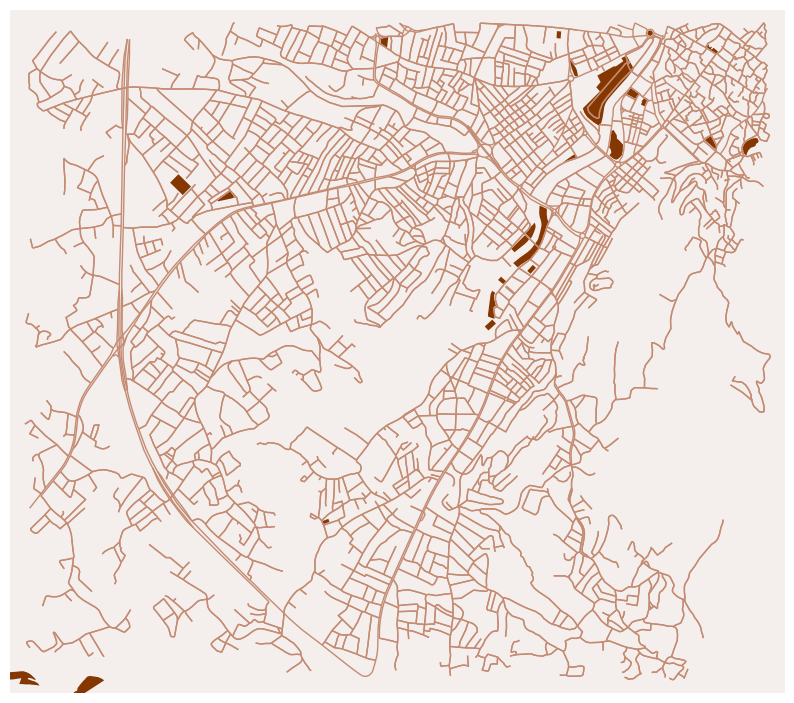

In [22]:
# Show the sportsfields and the roadnetwork 
lg.visualization_network_and_footprints(graph, filtered_sportsfield_gdf)

In [ ]:
# retrieve water information
river = {"natural": 'water'}
water = ox.features_from_bbox(n,e,s,w, river)
small_water = {"waterway": True}

small_water_graph = ox.features_from_bbox(n,e,s,w, small_water)

fig1, ax1 = ox.plot_footprints(filtered_sportsfield_gdf, color='#c7aa9d', bgcolor='#f5f1ee', show=False, close=False, figsize=(10,10))
fig2, ax2 = ox.plot_graph(graph, ax=ax1,  bgcolor='w', node_size=0, edge_color= '#767675', show=False, close=False, figsize=(10,10))
small_water_graph.plot(ax=ax2, markersize=20, color = "#cbc9c6" , alpha=1)

<AxesSubplot:>

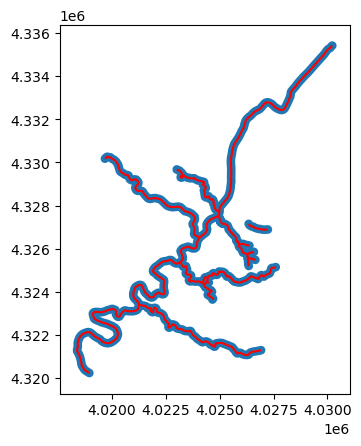

In [7]:
#calculate water buffer
small_water_graph = small_water_graph.to_crs(3857)
water_buf = small_water_graph.buffer(distance = 200)
bp = water_buf.plot()
small_water_graph.plot(ax=bp, color='red')


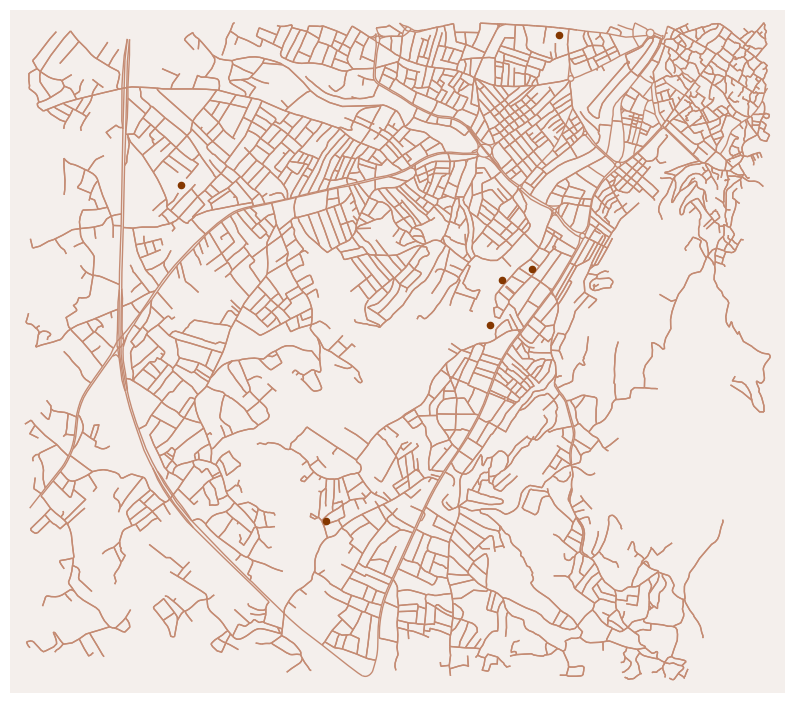

In [10]:
sportsfield_centers = filtered_sportsfield_gdf['geometry'].centroid

# Show the sportsfields and the roadnetwork 
lg.visualization_network_and_places(graph, sportsfield_centers)

In [12]:
from libpysal.cg.voronoi  import voronoi_frames

# Extract the coordinates of the centroids
coords = [(point.x, point.y) for point in sportsfield_centers]
region_df, point_df = voronoi_frames(coords, clip=box(w-10, s-10, e+10, n+10))

# Create a GeoDataFrame from the Voronoi polygons
voronoi_gdf = gpd.GeoDataFrame(region_df)
voronoi_gdf = voronoi_gdf.set_crs('EPSG:4326')


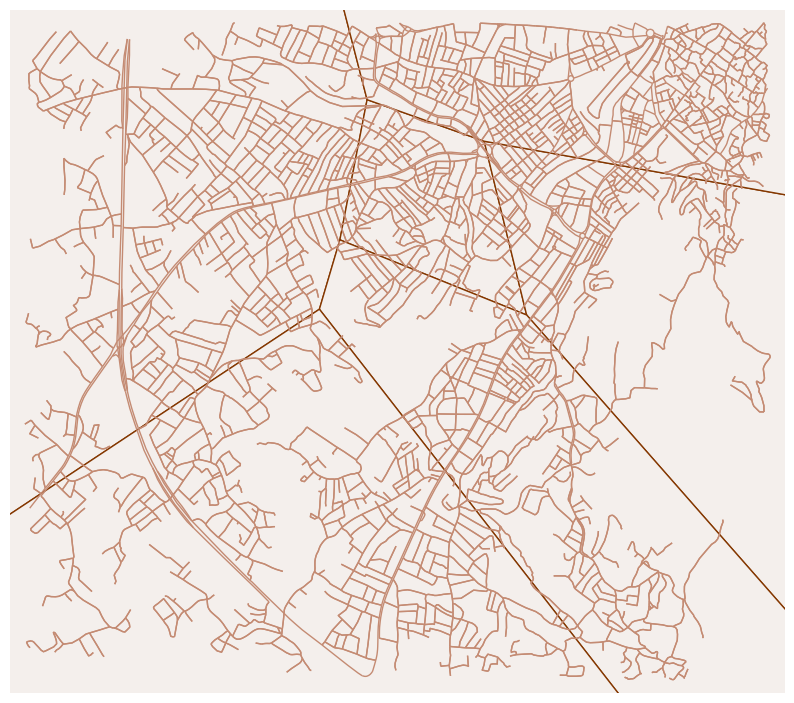

In [13]:
lg.visualization_network_and_footprints(graph, voronoi_gdf, edge = True)

<AxesSubplot:>

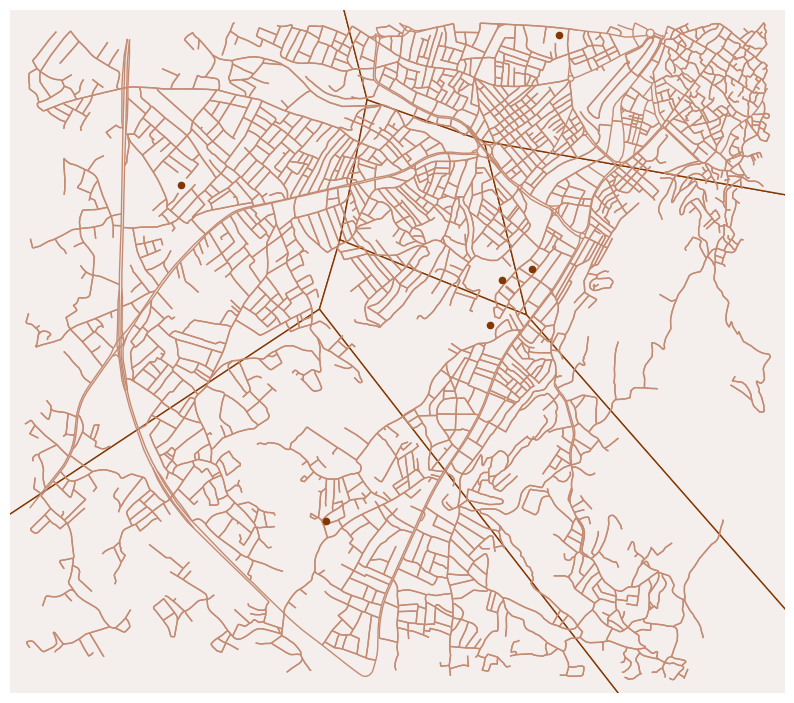

In [14]:
fig1, ax1 = ox.plot_footprints(voronoi_gdf, color='#f4efec', edge_color='#843700', edge_linewidth=1,  bgcolor='#f4efec', show=False, close=False, figsize=(10,10))
fig2, ax2 = ox.plot_graph(graph, ax=ax1,  bgcolor='w', node_size=0, edge_color= '#c48b73', show=False, close=False, figsize=(10,10))
sportsfield_centers.plot(ax=ax2, markersize = 20, color = "#843700" , alpha=1)

In [15]:
# save relevant geodataframes to file
voronoi_gdf.to_file("data/voronoi_gdf", driver=None, schema=None, index=None)